### Упражнение 1
* Реализуйте функцию `get_geodesic_distance`, рассчитывающее геодезическое расстояние между двумя точками в километрах.

In [1]:
!pip install geopandas

     |████████████████████████████████| 1.0MB 4.0MB/s 
     |████████████████████████████████| 6.5MB 24.0MB/s 
     |████████████████████████████████| 15.3MB 234kB/s 


In [2]:
from geopy.distance import geodesic
from shapely.geometry import Point
import geopandas as gpd

In [172]:
def get_geodesic_distance(point_1, point_2):
    x,y = (point_1.x, point_1.y), (point_2.x, point_2.y)
    return(geodesic(x, y).km)
    #distance = ((abs(point_1.x - point_2.x))**2 + (abs(point_1.y - point_2.y))**2)**0.5
    #return distance

In [173]:
# Сигнатура функции и пример вывода:

mipt = Point(55.9297243, 37.5199434) 
kremlin = Point(55.752023, 37.6174994)

get_geodesic_distance(mipt, kremlin)

20.707551240164566

### Упражнение 2

* Реализуйте функцию `get_k_nearest_neighbours_by_dist`, осуществляющую поиск `k` ближайших соседей полигона из заданного списка на основе геодезического расстояния. Добавьте две возможности учета расстояния: через ближайшие точки на границах полигонов и через центроиды полигонов.

In [148]:
from shapely.ops import nearest_points
import random
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


In [174]:
def get_k_nearest_neighbours_by_dist(polygon, polygons, k, kind):
    gs = gpd.GeoSeries(polygons)
    res = pd.DataFrame(gs, columns = ['geometry'])
    dist = []
        
    if kind == 'by_centroid':
        my_centr = polygon.centroid
        for point in gs.centroid:
            dist.append(get_geodesic_distance(my_centr, point))
                    
    if kind == 'by_board':
        for pol in polygons:
            point_1, point_2 = gpd.GeoSeries(nearest_points(polygon, pol))
            dist.append(get_geodesic_distance(point_1, point_2))
        
    res.insert(0, 'dist', dist)
    res.sort_values('dist', inplace = True)
    return res[:k]

In [202]:
# Сигнатура функции и пример вывода:

big_moscow_districts = gpd.read_file('big_moscow_districts.shp')
polygon = random.sample(big_moscow_districts['geometry'].tolist(), 1)[0]
polygons = random.sample(big_moscow_districts['geometry'].tolist(), 50)

k_nearest_neighbours_by_board = get_k_nearest_neighbours_by_dist(polygon, polygons, k=10, kind='by_board')
k_nearest_neighbours_by_centroid = get_k_nearest_neighbours_by_dist(polygon, polygons, k=10, kind='by_centroid')
k_nearest_neighbours_by_centroid

,dist,geometry
42,7.069859,"POLYGON ((37.46989 55.84318, 37.47035 55.84273..."
48,9.707601,"POLYGON ((37.36539 55.77181, 37.36552 55.77190..."
36,11.228494,"POLYGON ((37.43648 55.87958, 37.43749 55.87989..."
11,12.605602,"POLYGON ((37.40216 55.69884, 37.40142 55.69831..."
25,15.548010,"POLYGON ((37.49857 55.72285, 37.49774 55.72250..."
30,16.212143,"POLYGON ((37.41748 55.68078, 37.41732 55.68089..."
37,17.190881,"POLYGON ((37.47370 55.88530, 37.47593 55.88586..."
22,18.140086,"POLYGON ((37.56054 55.84484, 37.55877 55.84410..."
1,20.830528,"POLYGON ((37.57377 55.84848, 37.57358 55.84851..."
49,20.842867,"MULTIPOLYGON (((37.21692 55.62186, 37.21784 55..."


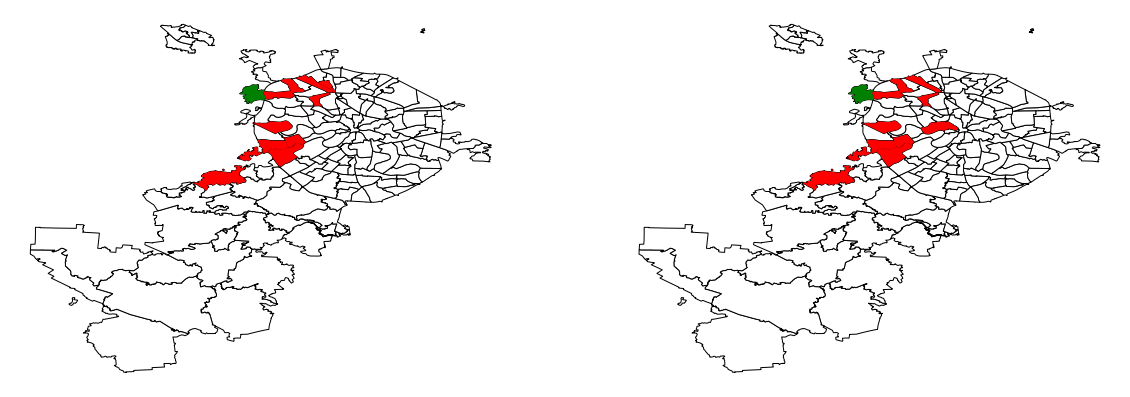

In [205]:
###

fig = plt.figure(figsize=(20, 10))

ax = plt.subplot(1, 2, 1)
big_moscow_districts.plot(ax=ax, color='white', edgecolor='black')
gpd.GeoSeries(k_nearest_neighbours_by_centroid['geometry'].values).plot(ax=ax, color='red')
gpd.GeoSeries(polygon).plot(ax=ax, color='green')
ax.set_axis_off()

ax = plt.subplot(1, 2, 2)
big_moscow_districts.plot(ax=ax, color='white', edgecolor='black')
gpd.GeoSeries(k_nearest_neighbours_by_board['geometry'].values).plot(ax=ax, color='red')
gpd.GeoSeries(polygon).plot(ax=ax, color='green')
ax.set_axis_off()

### Упражнение 4
* Отобразите результаты упражнений 2 и 3 (рисунки с `###`) на интерактивной карте в `Folium`

In [206]:
import folium
import geopy # объединенное API для популярных гео-кодирующих сервисов
from geopy.geocoders import Yandex

with open('api_key.txt', 'r') as f:  # считываем текстовый файл
    api_key = f.read()
    
geolocator_ya = Yandex(api_key=api_key)

In [228]:
from geopandas import GeoDataFrame

GDF = GeoDataFrame(k_nearest_neighbours_by_centroid, crs='EPSG:4326')

In [233]:
m = folium.Map(location=[55.755826, 37.6172999], # Москва
               zoom_start=8.5)
m.choropleth(GeoDataFrame(big_moscow_districts, crs='EPSG:4326'), fill_color='white')
m.choropleth(GDF, fill_color='red')
m.choropleth(polygon, fill_color='green')

m

/usr/local/lib/python3.7/dist-packages/folium/folium.py:426: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning
